# Quantum Approximate Optimization Algorithm (QAOA) – Max-Cut

> **Note:** This notebook follows the IBM Qiskit tutorial [Solve utility-scale quantum optimization problems](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm), but has been adapted to solve a larger random graph (n=15) and to run entirely on a local simulator (Qiskit Aer) rather than IBM’s cloud backends.

The **Quantum Approximate Optimization Algorithm (QAOA)** is a hybrid quantum-classical variational algorithm designed to tackle combinatorial optimization problems by parameterizing a quantum circuit whose expectation value approximates the minimum of a cost Hamiltonian, then using a classical optimizer to tune those parameters.

The **Max-Cut** problem asks: given an undirected graph, partition its vertices into two sets such that the number (or total weight) of edges between the sets is maximized. Max-Cut is NP-hard, making it an ideal testbed for quantum heuristics.




In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from typing import Sequence
from itertools import product

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz


## Generate a Random Graph

We create an Erdős–Rényi graph with `n=15` nodes, where each possible edge is included with probability `p=0.4`.  
We fix a random seed for reproducibility and visualize the resulting graph.


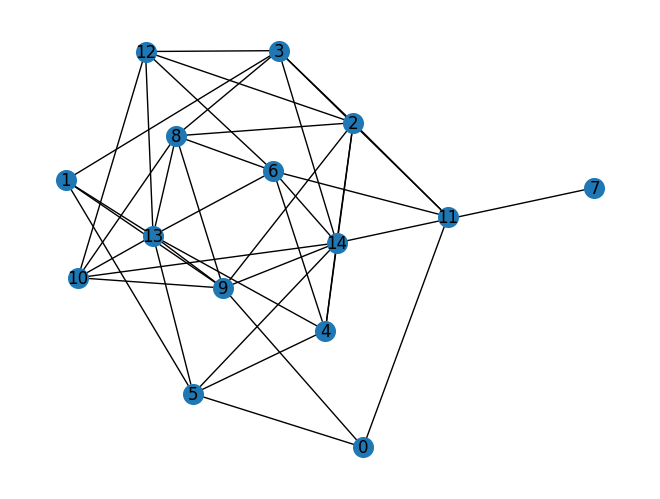

In [2]:
n = 15
p = 0.4  # probability of edge

graph = rx.PyGraph()
graph.add_nodes_from(range(n))

rng = np.random.default_rng(seed=42)
for i in range(n):
    for j in range(i + 1, n):
        if rng.random() < p:
            graph.add_edge(i, j, 1.0)

draw_graph(graph, node_size=200, with_labels=True)

## Map Max-Cut to a QUBO / Hamiltonian

Here we:
- Define the helper `build_max_cut_paulis` to convert graph edges into Pauli-Z operators.  
- Assemble the cost Hamiltonian $H_C = \sum_{(i,j)\in E} Z_i Z_j$.  
- Print out the resulting `SparsePauliOp` representation.


In [3]:

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    # Iterate over each edge (u, v) in the graph
    for u, v in graph.edge_list():
        # Start with identity on all qubits
        paulis = ["I"] * len(graph)
        # Place Z on the two qubits corresponding to the edge endpoints
        paulis[u], paulis[v] = "Z", "Z"
        
        # Retrieve the weight of the edge (u, v)
        weight = graph.get_edge_data(u, v)
        
        # Join into a Pauli string, reverse to match Qiskit endianness, and store with weight
        pauli_str = "".join(paulis)[::-1]
        pauli_list.append((pauli_str, weight))

    return pauli_list

# Build the list of (Pauli string, weight) for every edge
max_cut_paulis = build_max_cut_paulis(graph)

# Construct the sparse Pauli operator (the cost Hamiltonian)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIZIIIIZ', 'IIIIIZIIIIIIIIZ', 'IIIZIIIIIIIIIIZ', 'IIIIIIIIIIIZIZI', 'IIIIIIIIIZIIIZI', 'IIIIIZIIIIIIIZI', 'IZIIIIIIIIIIIZI', 'IIIIIIIIIIIZZII', 'IIIIIIIIIIZIZII', 'IIIIIIZIIIIIZII', 'IIIIIZIIIIIIZII', 'IIIZIIIIIIIIZII', 'IIZIIIIIIIIIZII', 'ZIIIIIIIIIIIZII', 'IIIIIIZIIIIZIII', 'IIIZIIIIIIIZIII', 'IIZIIIIIIIIZIII', 'ZIIIIIIIIIIZIII', 'IIIIIIIIIZZIIII', 'IIIIIIIIZIZIIII', 'IZIIIIIIIIZIIII', 'ZIIIIIIIIIZIIII', 'IZIIIIIIIZIIIII', 'ZIIIIIIIIZIIIII', 'IIIIIIZIZIIIIII', 'IIIZIIIIZIIIIII', 'IIZIIIIIZIIIIII', 'IZIIIIIIZIIIIII', 'ZIIIIIIIZIIIIII', 'ZIIIIIIZIIIIIII', 'IIIIIZZIIIIIIII', 'IIIIZIZIIIIIIII', 'IZIIIIZIIIIIIII', 'IIIIZZIIIIIIIII', 'IZIIIZIIIIIIIII', 'ZIIIIZIIIIIIIII', 'IIZIZIIIIIIIIII', 'IZIIZIIIIIIIIII', 'ZIIIZIIIIIIIIII', 'IZZIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.

### Build the QAOA Ansatz

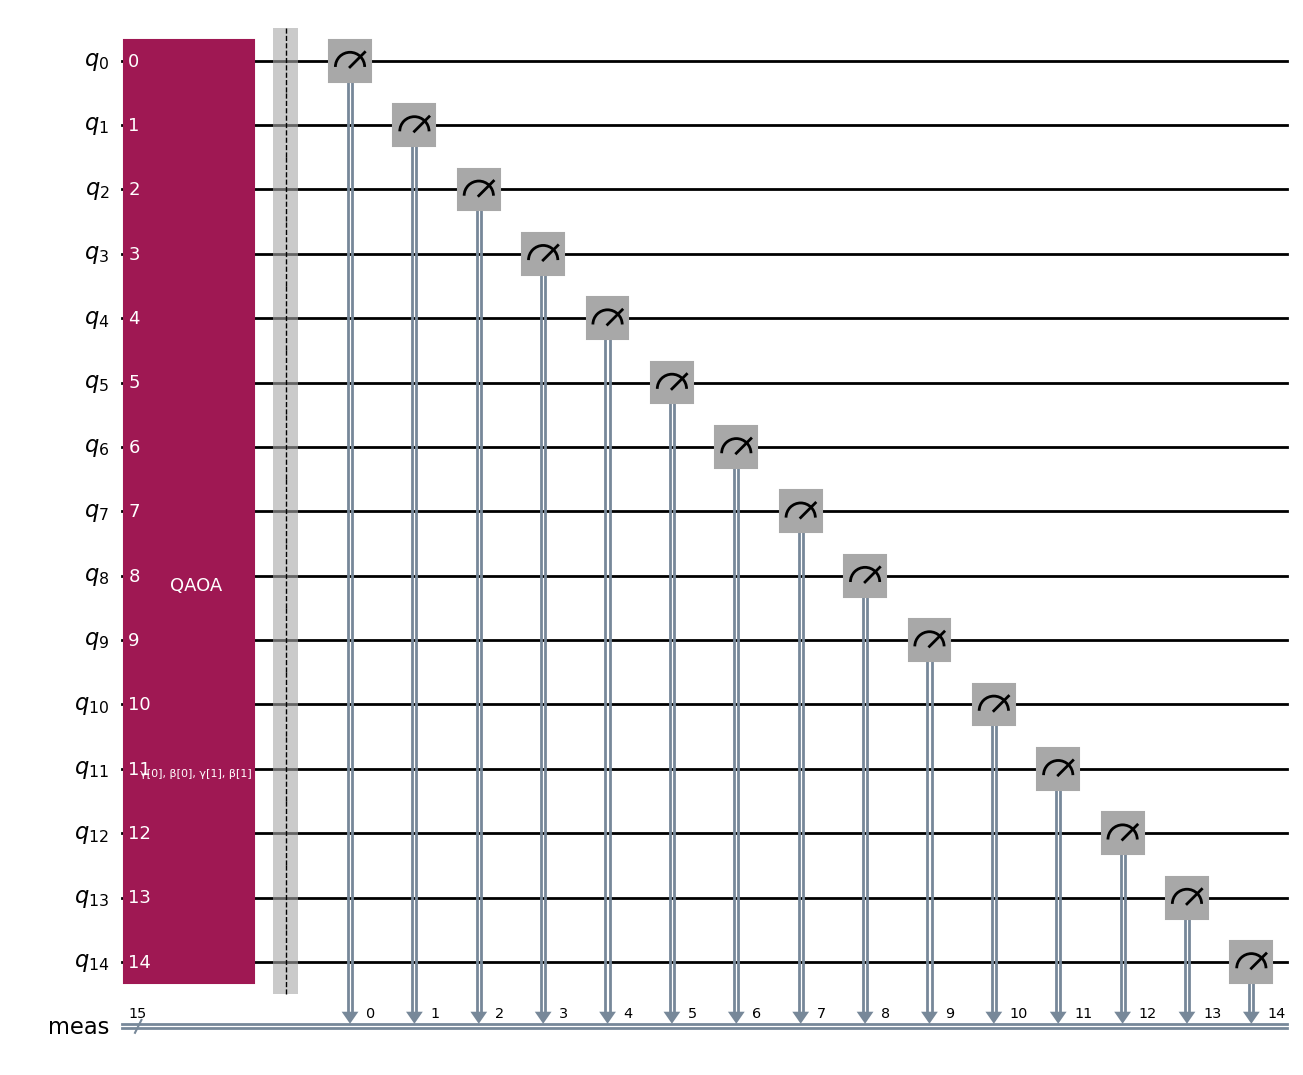

In [4]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

### Initialize QAOA Parameters

We choose an initial guess $\gamma = \pi$, $\beta = \pi/2$ for each layer, resulting in 4 parameters for `reps=2`.


In [5]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

### Define the Cost Function

We wrap Qiskit’s `Estimator` primitive to evaluate the expectation value $\langle H_C\rangle$ for a given parameter set.  
This will feed into a classical optimizer.


In [6]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    try:
        isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    except AttributeError:
        isa_hamiltonian = hamiltonian

    # Use explicit argument structure for Estimator.run
    job = estimator.run(
        circuits=[ansatz],
        observables=[isa_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]

    objective_func_vals.append(cost)
    return cost


### Classical Optimization Loop

We use SciPy’s `COBYLA` to find the parameters that minimize the cost.  
The global list `objective_func_vals` will record the cost at each iteration.


In [7]:
from qiskit_aer.primitives import Estimator
from scipy.optimize import minimize

# Create local Estimator
estimator = Estimator()
objective_func_vals = []  # Global variable to track cost evolution

# Run optimization
result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-3,
)

# Display result
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -8.421875
       x: [ 4.351e+00  3.086e+00  3.357e+00  1.237e+00]
    nfev: 47
   maxcv: 0.0


Here we plot the cost evolution. We visualize how the expectation value of $H_C$ decreases over the optimizer’s iterations gives insight into convergence.


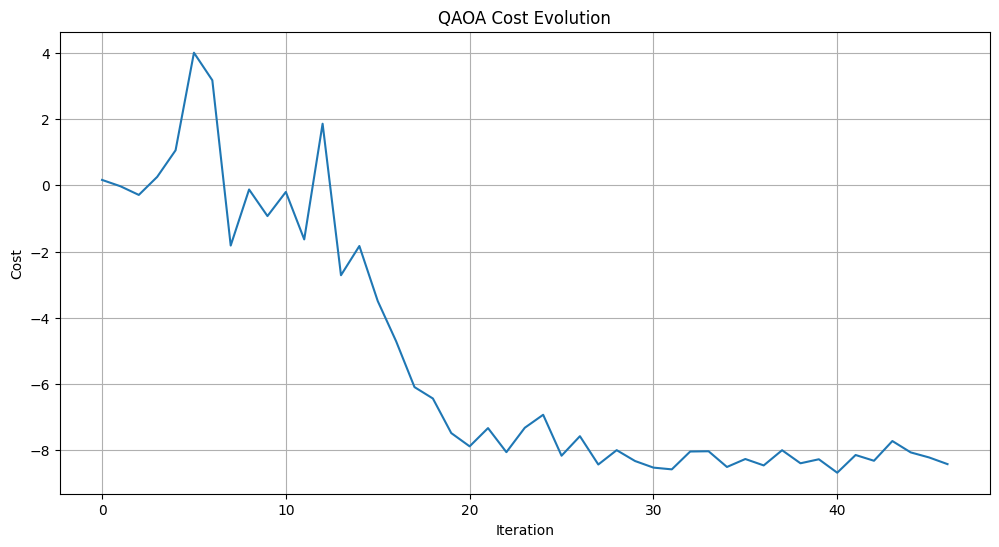

In [8]:
import matplotlib.pyplot as plt
# Plot cost function evolution
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("QAOA Cost Evolution")
plt.grid(True)
plt.show()

## 7. Construct the Optimized Circuit and find the Optimal State

We bind the optimal $\{\gamma^*,\beta^*\}$ into the ansatz to get our final variational circuit. Using Qiskit-Aer’s `Sampler` primitive, we draw 1,000 shots from the optimized circuit’s output distribution.



In [9]:
# Build the optimized circuit with the optimal parameters
optimized_circuit = circuit.assign_parameters(result.x)

# Create a local sampler (uses AerSimulator under the hood)
sampler = Sampler()

# Run the sampler
job = sampler.run(circuits=[optimized_circuit], shots=1000)
result = job.result()

# Extract counts
quasi_dists = result.quasi_dists[0]

# Convert quasi-probabilities to integer bitstrings
# (you get float values keyed by int outcomes)
final_distribution_int = {k: v for k, v in quasi_dists.items()}
final_distribution_bin = {format(k, f"0{optimized_circuit.num_qubits}b"): v for k, v in quasi_dists.items()}


### Identify the Best Cut

We convert the quasi-probabilities into classical probabilities, pick the bitstring with highest frequency, and reverse it to match our node ordering.


In [10]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]


### Distribution of Measured Bitstrings

A bar chart of the full output distribution; the four most likely bitstrings are highlighted.


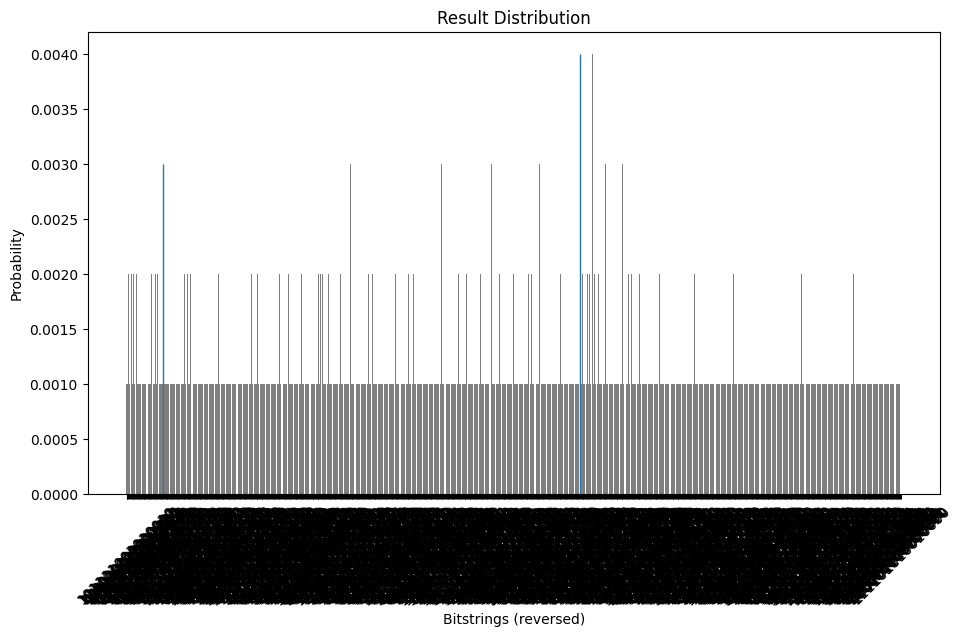

In [11]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:blue")
plt.show()

### Visualize the Cut

Nodes colored by the bit value (0 = grey, 1 = purple) show the two partitions that maximize the number of edges across the cut.


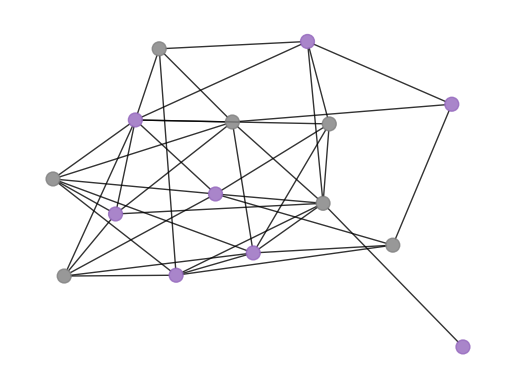

In [12]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

## Compute Cut Value

We verify the objective by counting how many edges cross the partition defined by our bitstring. As we're considering a small graph, we compare the result with a classical brute force count.


In [13]:
# QAOA algorithm
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)

# Exact brute force
if n<16:
    best_val = 0
    for bits in product([0,1], repeat=n):
        val = sum(
            bits[u] * (1 - bits[v]) + bits[v] * (1 - bits[u])
            for u, v in graph.edge_list()
        )
        best_val = max(best_val, val)
else: best_val=None

print(f"Exact classical optimum: {best_val}")
print(f"QAOA cut value:           {cut_value}")


Exact classical optimum: 31
QAOA cut value:           31
